# Assignment 3 - Convection of a Scalar

Solve the following problems and explain your results.

## Problem 1

Consider a convection/diffusion problem that has Dirichlet conditions on temperature imposed on both ends (see the figure below). This is an unusual problem that would be difficult to reproduce in a laboratory, but it is an interesting problem by which to observe the performance of advection schemes.

![Problem1](Figures/3-Problem1.png)
   
The exact solution to this problem is given by:

$$
    T(x)= T_1 + \frac{e^{x Pe/L} - 1}{e^{Pe} - 1}(T_2 - T_1)
$$

where $Pe$ is defined as $Pe= u L/\alpha$.  Solve this problem numerically for $Pe = 50$ by imposing:

- $L$ = 1 [m]
- $\rho$ = 1 [kg/m$^3$]
- $c_p$ = 1 [J/kg$\cdot$K]
- $u$ = 1 [m/s]
- $k$ = 0.02 [[W/m$\cdot$K]]
- $T_1$ = 0 [$^\circ$C]
- $T_2$ = 1 [$^\circ$C]

Discretize the one-dimensional domain using 10 equal sized control-volumes.  Initialize the field variables as $T$ = 0.0 [K] and $u$ = 1 [m/s]. Then, carry out the following:

1. Solve the problem using UDS, CDS, and QUICK (use $\Delta t = 10^{10}$ [s]).  Modify the value of $\alpha_e$ on the domain boundaries such that the value of temperature on the face is equal to the specified boundary temperature.
2. Plot the results for $T$ for all cases along with the exact solution. Discuss your results.
4. Re-run the case using 20, 40 and 80 uniformly spaced control volumes.  Discuss your results.

# Solution problem 1

In [506]:
import numpy as np

class UpwindAdvectionModel:
    """Class defining an upwind advection model"""

    def __init__(self, grid, phi, Uhe, rho, cp, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._cp = cp
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)

    def add(self, coeffs):
        """Function to add advention terms to coefficient arrays"""

        # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
            else:
                self._alphae[i] = -1
        
        #To modify the value of alphae on the domains boundaries
        self._alphae [-1] = -1
        
        # Calculate the east integration point values (including both boundaries)
        self._phie = (1 + self._alphae)/2*self._phi[0:-1] + (1 - self._alphae)/2*self._phi[1:]
        
        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = self._cp*mdote[:-1]*self._phie[:-1]
        flux_e = self._cp*mdote[1:]*self._phie[1:]
        
        # Calculate mass imbalance term
        imbalance = - self._cp*mdote[1:]*self._phi[1:-1] + self._cp*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._cp*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._cp*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs

In [507]:
class CenteredAdvectionModel:
    """Class defining an upwind advection model with a central difference scheme"""

    def __init__(self, grid, phi, Uhe, rho, cp, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._cp = cp
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)

    def add(self, coeffs):
        """Function to add advention terms to coefficient arrays"""

        # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
            else:
                self._alphae[i] = -1
        
        self._alphae [-1] = -1
        
        # Calculate the east integration point values (including both boundaries)
        self._phie[1:-1] = (self._phi[1:-2] + self._phi[2:-1])/2
        self._phie [0] = (1 + self._alphae[0])/2*self._phi[0] + (1 - self._alphae[0])/2*self._phi[1]
        self._phie[-1] = (1 + self._alphae[-1])/2*self._phi[-2] + (1 - self._alphae[-1])/2*self._phi[-1]
        
        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = (self._cp*mdote[:-1])*self._phie[:-1]
        flux_e = (self._cp*mdote[1:])*self._phie[1:]
        
        #flux_w = self._cp*mdote[:-1]*self._phie[:-1]
        #flux_e = self._cp*mdote[1:]*self._phie[1:]
        
        # Calculate mass imbalance term
        imbalance = - self._cp*mdote[1:]*self._phi[1:-1] + self._cp*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._cp*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._cp*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs

In [508]:
import numpy as np

class QUICKAdvectionModel:
    """Class defining an upwind advection model with the QUICK scheme"""

    def __init__(self, grid, phi, Uhe, rho, cp, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._cp = cp
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)

    def add(self, coeffs):
        """Function to add advention terms to coefficient arrays"""

        # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
            else:
                self._alphae[i] = -1
        
        #To modify the value of alphae on the domains boundaries
        self._alphae [-1] = -1
        
        #To calculate the east integration point values of the interior control volume
        for i in range(self._grid.ncv):
            if self._Uhe[i] >= 0:
                TW = (((self._grid.xf[i] - self._grid.xP[i])*(self._grid.xf[i] - self._grid.xP[i+1]))/((self._grid.xP[i-1] - self._grid.xP[i])*(self._grid.xP[i-1] - self._grid.xP[i+1])))*self._phi[i-1]
                TP = ((self._grid.xf[i]-self._grid.xP[i-1])*(self._grid.xf[i]-self._grid.xP[i+1]))/((self._grid.xP[i]-self._grid.xP[i-1])*(self._grid.xP[i]-self._grid.xP[i+1]))*self._phi[i]
                TE = ((self._grid.xf[i]-self._grid.xP[i-1])*(self._grid.xf[i]-self._grid.xP[i]))/((self._grid.xP[i+1]-self._grid.xP[i-1])*(self._grid.xP[i+1]-self._grid.xP[i]))*self._phi[i+1] 
                self._phie[i] = TW + TP + TE
            else:
                for i in range(self._grid.ncv-1):
                    T_EE = (((self._grid.xf[i] - self._grid.xP[i+1])*(self._grid.xf[i] - self._grid.xP[i]))/((self._grid.xP[i+2] - self._grid.xP[i+1])*(self._grid.xP[i+2] - self._grid.xP[i])))*self._phi[i+2]
                    T_E = ((self._grid.xf[i] - self._grid.xP[i+2])*(self._grid.xf[i] - self._grid.xP[i]))/((self._grid.xP[i+1] - self._grid.xP[i+2])*(self._grid.xP[i+1] - self._grid.xP[i]))*self._phi[i+1]
                    T_P = ((self._grid.xf[i] - self._grid.xP[i+2])*(self._grid.xf[i] - self._grid.xP[i+1]))/((self._grid.xP[i+1] - self._grid.xP[i+2])*(self._grid.xP[i] - self._grid.xP[i+1]))*self._phi[i] 
                    self._phie[i] = T_EE + T_E + T_P

        # Calculate the east integration point values for the boundaries
        self._phie [0] = (1 + self._alphae[0])/2*self._phi[0] + (1 - self._alphae[0])/2*self._phi[1]
        self._phie[-1] = (1 + self._alphae[-1])/2*self._phi[-2] + (1 - self._alphae[-1])/2*self._phi[-1]

        
        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = self._cp*mdote[:-1]*self._phie[:-1]
        flux_e = self._cp*mdote[1:]*self._phie[1:]
        
        # Calculate mass imbalance term
        imbalance = - self._cp*mdote[1:]*self._phi[1:-1] + self._cp*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._cp*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._cp*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs

## Upwind Difference Scheme

In [509]:
from Classes.Grid import Grid
from Classes.ScalarCoeffs import ScalarCoeffs
from Classes.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Classes.Models import DiffusionModel, SurfaceConvectionModel, FirstOrderTransientModel
from Classes.LinearSolver import solve

import numpy as np
from numpy.linalg import norm

def UDS(ncv1):

    # Define the grid
    lx = 1.0
    ly = 0.1
    lz = 0.1
    ncv = ncv1
    grid = Grid(lx, ly, lz, ncv)

    # Set the timestep information
    nTime = 1
    dt = 1e9
    time = 0

    # Set the maximum number of iterations and convergence criterion
    maxIter = 100
    converged = 1e-6

    # Define thermophysical properties
    rho = 1
    cp = 1
    k = 0.02

    # Define the coefficients
    coeffs = ScalarCoeffs(grid.ncv)

    # Initial conditions
    T0 = 0
    U0 = 1

    # Initialize field variable arrays
    T = T0*np.ones(grid.ncv+2)
    Uhe = U0*np.ones(grid.ncv+1)

    # Define boundary conditions
    west_bc = DirichletBc(T, grid, 0, BoundaryLocation.WEST)
    east_bc = DirichletBc(T, grid, 1, BoundaryLocation.EAST)

    # Apply boundary conditions
    west_bc.apply()
    east_bc.apply()

    # Define the transient model
    Told = np.copy(T)
    transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

    # Define the diffusion model
    diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

    # Define the advection model
    advection = UpwindAdvectionModel(grid, T, Uhe, rho, cp, west_bc, east_bc)

    # Loop through all timesteps
    for tStep in range(nTime):
        # Update the time information
        time += dt

        # Print the timestep information
        print("Timestep = {}; Time = {}".format(tStep, time))

        # Store the "old" temperature field
        Told[:] = T[:]

        # Iterate until the solution is converged
        for i in range(maxIter):
            # Zero the coefficients and add each influence
            coeffs.zero()
            coeffs = diffusion.add(coeffs)
            coeffs = advection.add(coeffs)
            coeffs = transient.add(coeffs)

            # Compute residual and check for convergence 
            maxResid = norm(coeffs.rP, np.inf)
            avgResid = np.mean(np.absolute(coeffs.rP))
            print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
            if maxResid < converged:
                break

            # Solve the sparse matrix system
            dT = solve(coeffs)

            # Update the solution and boundary conditions
            T[1:-1] += dT
            west_bc.apply()
            east_bc.apply()
            
    return (T, grid.xP)


In [510]:
#UDS for a number of control volumes of 10
T_UDS1, grid1 = UDS(10)

#UDS for a number of control volumes of 20
T_UDS2, grid2 = UDS(20)

#UDS for a number of control volumes of 40
T_UDS3, grid3 = UDS(40)

#UDS for a number of control volumes of 80
T_UDS4, grid4 = UDS(80)

Timestep = 0; Time = 1000000000.0
Iteration = 0; Max. Resid. = 0.0060000000000000045; Avg. Resid. = 0.0006000000000000005
Iteration = 1; Max. Resid. = 1.6186561484486144e-18; Avg. Resid. = 1.8642235209581962e-19
Timestep = 0; Time = 1000000000.0
Iteration = 0; Max. Resid. = 0.0019999999999999723; Avg. Resid. = 9.999999999999861e-05
Iteration = 1; Max. Resid. = 7.042460704797287e-19; Avg. Resid. = 5.447947392095242e-20
Timestep = 0; Time = 1000000000.0
Iteration = 0; Max. Resid. = 0.006000000000000057; Avg. Resid. = 0.00015000000000000142
Iteration = 1; Max. Resid. = 1.3955383274109578e-18; Avg. Resid. = 4.078630571981359e-20
Timestep = 0; Time = 1000000000.0
Iteration = 0; Max. Resid. = 0.022000000000000117; Avg. Resid. = 0.0002750000000000015
Iteration = 1; Max. Resid. = 4.1704477156151555e-18; Avg. Resid. = 1.064177416889726e-19


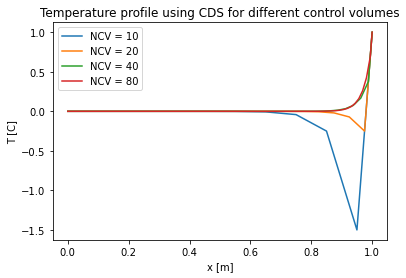

In [511]:
%matplotlib inline
import matplotlib.pyplot as plt

fig1, ax = plt.subplots()


ax.plot(grid1, T_UDS1, label="NCV = 10")
ax.plot(grid2, T_UDS2, label="NCV = 20")
ax.plot(grid3, T_UDS3, label="NCV = 40")
ax.plot(grid4, T_UDS4, label="NCV = 80")


ax.set_title("Temperature profile using CDS for different control volumes")
ax.set_xlabel("x [m]")
ax.set_ylabel("T [C]")
ax.legend()
plt.show()

## Central Difference Scheme (CDS)

In [512]:
##FOR CENTRAL DIFFERENCE SCHEME

def CDS (ncv1):

    # Define the grid
    lx = 1.0
    ly = 0.1
    lz = 0.1
    ncv = ncv1
    grid = Grid(lx, ly, lz, ncv)

    # Set the timestep information
    nTime = 1
    dt = 10e10
    time = 0

    # Set the maximum number of iterations and convergence criterion
    maxIter = 10
    converged = 1e-6

    # Define thermophysical properties
    rho = 1
    cp = 1
    k = 0.02

    # Define the coefficients
    coeffs = ScalarCoeffs(grid.ncv)

    # Initial conditions
    T0 = 0
    U0 = 1

    # Initialize field variable arrays
    T = T0*np.ones(grid.ncv+2)
    Uhe = U0*np.ones(grid.ncv+1)

    # Define boundary conditions
    west_bc = DirichletBc(T, grid, 0, BoundaryLocation.WEST)
    east_bc = DirichletBc(T, grid, 1, BoundaryLocation.EAST)

    # Apply boundary conditions
    west_bc.apply()
    east_bc.apply()

    # Define the transient model
    Told = np.copy(T)
    transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

    # Define the diffusion model
    diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

    # Define the advection model
    advection = CenteredAdvectionModel(grid, T, Uhe, rho, cp, west_bc, east_bc)

    # Loop through all timesteps
    for tStep in range(nTime):
        # Update the time information
        time += dt

        # Print the timestep information
        print("Timestep = {}; Time = {}".format(tStep, time))

        # Store the "old" temperature field
        Told[:] = T[:]

        # Iterate until the solution is converged
        for i in range(maxIter):
            # Zero the coefficients and add each influence
            coeffs.zero()
            coeffs = diffusion.add(coeffs)
            coeffs = advection.add(coeffs)
            coeffs = transient.add(coeffs)

            # Compute residual and check for convergence 
            maxResid = norm(coeffs.rP, np.inf)
            avgResid = np.mean(np.absolute(coeffs.rP))
            print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
            if maxResid < converged:
                break

            # Solve the sparse matrix system
            dT = solve(coeffs)

            # Update the solution and boundary conditions
            T[1:-1] += dT
            west_bc.apply()
            east_bc.apply()
            
        
            
    return (T, grid.xP)

In [513]:
T_CDS1, grid1 = CDS(10)
T_CDS2, grid2 = CDS(20)
T_CDS3, grid3 = CDS(40)
T_CDS4, grid4 = CDS(80)



Timestep = 0; Time = 100000000000.0
Iteration = 0; Max. Resid. = 0.0060000000000000045; Avg. Resid. = 0.0006000000000000005
Iteration = 1; Max. Resid. = 0.006249999734190473; Avg. Resid. = 0.001249999946838095
Iteration = 2; Max. Resid. = 0.004340281746190348; Avg. Resid. = 0.0008680563492380697
Iteration = 3; Max. Resid. = 0.002712644078661524; Avg. Resid. = 0.0005887446710998798
Iteration = 4; Max. Resid. = 0.0016325988067222553; Avg. Resid. = 0.0004245776098018456
Iteration = 5; Max. Resid. = 0.0011774502533086662; Avg. Resid. = 0.00029332892843522717
Iteration = 6; Max. Resid. = 0.0007521180267163978; Avg. Resid. = 0.00021287820449654467
Iteration = 7; Max. Resid. = 0.0005087178332219439; Avg. Resid. = 0.00014837087264301234
Iteration = 8; Max. Resid. = 0.00035579383936933887; Avg. Resid. = 0.00010703463437953232
Iteration = 9; Max. Resid. = 0.0002299079410688056; Avg. Resid. = 7.499710981372348e-05
Timestep = 0; Time = 100000000000.0
Iteration = 0; Max. Resid. = 0.0019999999999999

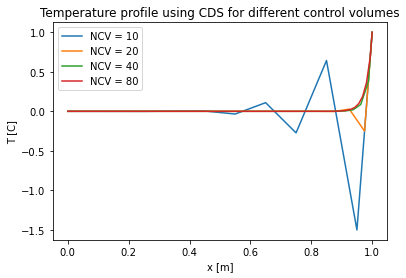

In [514]:
%matplotlib inline
import matplotlib.pyplot as plt

fig1, ax = plt.subplots()


ax.plot(grid1, T_CDS1, label="NCV = 10")
ax.plot(grid2, T_CDS2, label="NCV = 20")
ax.plot(grid3, T_CDS3, label="NCV = 40")
ax.plot(grid4, T_CDS4, label="NCV = 80")


ax.set_title("Temperature profile using CDS for different control volumes")
ax.set_xlabel("x [m]")
ax.set_ylabel("T [C]")
ax.legend()
plt.show()

## QUICK scheme

In [515]:
##FOR CENTRAL DIFFERENCE SCHEME

def QUICK(ncv1):
    # Define the grid
    lx = 1.0
    ly = 0.1
    lz = 0.1
    ncv = ncv1
    grid = Grid(lx, ly, lz, ncv)

    # Set the timestep information
    nTime = 1
    dt = 1e9
    time = 0

    # Set the maximum number of iterations and convergence criterion
    maxIter = 10
    converged = 1e-6

    # Define thermophysical properties
    rho = 1
    cp = 1
    k = 0.02

    # Define the coefficients
    coeffs = ScalarCoeffs(grid.ncv)

    # Initial conditions
    T0 = 0
    U0 = 1

    # Initialize field variable arrays
    T = T0*np.ones(grid.ncv+2)
    Uhe = U0*np.ones(grid.ncv+1)

    # Define boundary conditions
    west_bc = DirichletBc(T, grid, 0, BoundaryLocation.WEST)
    east_bc = DirichletBc(T, grid, 1, BoundaryLocation.EAST)

    # Apply boundary conditions
    west_bc.apply()
    east_bc.apply()

    # Define the transient model
    Told = np.copy(T)
    transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

    # Define the diffusion model
    diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

    # Define the advection model
    advection = QUICKAdvectionModel(grid, T, Uhe, rho, cp, west_bc, east_bc)

    # Loop through all timesteps
    for tStep in range(nTime):
        # Update the time information
        time += dt

        # Print the timestep information
        print("Timestep = {}; Time = {}".format(tStep, time))

        # Store the "old" temperature field
        Told[:] = T[:]

        # Iterate until the solution is converged
        for i in range(maxIter):
            # Zero the coefficients and add each influence
            coeffs.zero()
            coeffs = diffusion.add(coeffs)
            coeffs = advection.add(coeffs)
            coeffs = transient.add(coeffs)

            # Compute residual and check for convergence 
            maxResid = norm(coeffs.rP, np.inf)
            avgResid = np.mean(np.absolute(coeffs.rP))
            print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
            if maxResid < converged:
                break

            # Solve the sparse matrix system
            dT = solve(coeffs)

            # Update the solution and boundary conditions
            T[1:-1] += dT
            west_bc.apply()
            east_bc.apply()
            
    return (T, grid.xP)

In [516]:
T_QUICK1, grid1 = QUICK(10)
T_QUICK2, grid2 = QUICK(20)
T_QUICK3, grid3 = QUICK(40)
T_QUICK4, grid4 = QUICK(80)


Timestep = 0; Time = 1000000000.0
Iteration = 0; Max. Resid. = 0.0060000000000000045; Avg. Resid. = 0.0006000000000000005
Iteration = 1; Max. Resid. = 0.004947916454836523; Avg. Resid. = 0.0009895832909673045
Iteration = 2; Max. Resid. = 0.0023622890939883593; Avg. Resid. = 0.00047245781879767183
Iteration = 3; Max. Resid. = 0.0007937288189329132; Avg. Resid. = 0.0001888670867604361
Iteration = 4; Max. Resid. = 0.00038585554830930133; Avg. Resid. = 8.239603820907694e-05
Iteration = 5; Max. Resid. = 0.00014893861443028046; Avg. Resid. = 3.551609405246811e-05
Iteration = 6; Max. Resid. = 6.031200768116157e-05; Avg. Resid. = 1.50174406651838e-05
Iteration = 7; Max. Resid. = 2.6677451243560644e-05; Avg. Resid. = 7.129423154339084e-06
Iteration = 8; Max. Resid. = 9.298917848965963e-06; Avg. Resid. = 3.0447517447249098e-06
Iteration = 9; Max. Resid. = 4.481307824408886e-06; Avg. Resid. = 1.3681661377636184e-06
Timestep = 0; Time = 1000000000.0
Iteration = 0; Max. Resid. = 0.00199999999999997

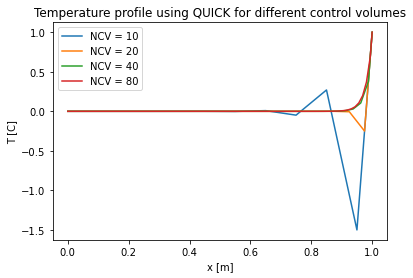

In [517]:
%matplotlib inline
import matplotlib.pyplot as plt

fig3, ax = plt.subplots()


ax.plot(grid1, T_QUICK1, label="NCV = 10")
ax.plot(grid2, T_QUICK2, label="NCV = 20")
ax.plot(grid3, T_QUICK3, label="NCV = 40")
ax.plot(grid4, T_QUICK4, label="NCV = 80")


ax.set_title("Temperature profile using QUICK for different control volumes")
ax.set_xlabel("x [m]")
ax.set_ylabel("T [C]")
ax.legend()
plt.show()

## Analytical Solution

In [518]:
#Define the grid for x values:

x_an = grid3
lx = 1.0

#Define Pe
Pe = 50

#Define Temperatures
T1 = 0
T2 = 1

#Temperature calculation

T_an = T1 + ((((np.exp((x_an*Pe)/lx))-1)/(np.exp(Pe)-1))*(T2-T1))

print (T_an)


[0.00000000e+00 1.67462926e-22 1.06482790e-21 4.19693944e-21
 1.51290829e-20 5.32860127e-20 1.86466784e-19 6.51313351e-19
 2.27378729e-18 7.93677779e-18 2.77025568e-17 9.66919043e-17
 3.37488388e-16 1.17795070e-15 4.11145240e-15 1.43503794e-14
 5.00877462e-14 1.74823413e-13 6.10193668e-13 2.12978517e-12
 7.43368067e-12 2.59460950e-11 9.05607699e-11 3.16088145e-10
 1.10325603e-09 3.85074192e-09 1.34404100e-08 4.69116402e-08
 1.63737713e-07 5.71500774e-07 1.99473370e-06 6.96230472e-06
 2.43008313e-05 8.48182352e-05 2.96044730e-04 1.03329764e-03
 3.60656314e-03 1.25881422e-02 4.39369336e-02 1.53354967e-01
 5.35261429e-01 1.00000000e+00]


## Discusion of results of each of the schemes for diferent numbers of control volumes

For all the schemes is possible to notice that for number of control volumes less than 40, the solution does not provide a good accuracy of the results. It is after 40 control volumes that the temperatures calculated provide a more accurate result and the result is independent of the number of control volumes. For 80 control volumes the result obtained for the profile temperatures is almost the same as the 40 ncv. It is possible to say that after 40 ncv the result is independent of the grid.

In order to compare the diverse schemes with the analytical result, the following figure shows the calculation of the temperature profiles using ncv of 40 for all the schemes.

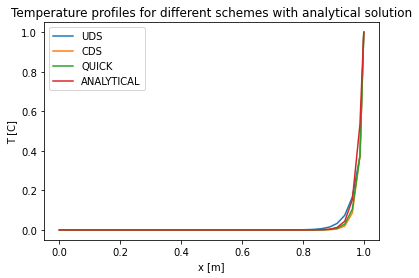

In [520]:
%matplotlib inline
import matplotlib.pyplot as plt

fig4, ax = plt.subplots()


ax.plot(x_an, T_UDS3, label="UDS")
ax.plot(x_an, T_CDS3, label="CDS")
ax.plot(x_an, T_QUICK3, label="QUICK")
ax.plot(x_an, T_an, label="ANALYTICAL")


ax.set_title("Temperature profiles for different schemes with analytical solution")
ax.set_xlabel("x [m]")
ax.set_ylabel("T [C]")
ax.legend()
plt.show()

## Discussion of the comparison between different schemes used:

From the previous figure is possible to notice that for this case all the schemes provide a similar temperature profile that is close to the analytical solution. Despite the fact that all the schemes provide a good approximation, is possible to notice that the QUICK and CDS schemes have a closer result between them than to the UDS scheme that is closer to the analytical result. 



## Problem 2

Consider the problem of water flowing through a heated square duct (see the figure below).

![Problem1](Figures/3-Problem2.png)

The properties of water are $\rho$ = 1000 [kg/m$^3$], $k$ = 0.590 [W/m$\cdot$K], and $c_p$ = 4189 [J/kg$\cdot$K]. The exact solution for this problem is:

$$
    \frac{T_{\infty}-T(x)}{T_{\infty}-T_{in}}= e^{-\frac{h P_o x}{\dot{m} c_p}}
$$

To solve this problem, start with 5 equal-length control volumes, initialize the temperature and velocity fields as $T$ = 0 [$^\circ$C] and $u$ = 1.5 [m/s], and use a time-step size of $10^{10}$ [s].  At the left boundary, set $\alpha_e = 1$ to ensure that the correct value of $T$ gets carried into the domain.  Then, carry out the following:

1. Solve the problem using UDS, CDS and QUICK and plot $T$ for all schemes along with $T_{exact}$ vs. $x$ with $\alpha_e$ = -1.0 at the right boundary.  Discuss the results.
2. Test the effect of $\alpha_e$ at the right boundary.  That is, set $\alpha_e$ = 1.0 at the right boundary, run the cases of (1) again and discuss the differences that occur.  What physical effect does setting $\alpha_e = \pm1.0$ at the right boundary have?  Which is realistic?
3. Reverse the flow direction and the boundary conditions re-run parts (1) and (2).  Show plots of $T$ vs. $x$.  Make sure you use appropriate values for $\alpha_e$ on the boundaries.  Your solutions should be the same as those from parts (1) and (2), except opposite.

Based on your results for this problem, make a general statement about how $\alpha_e$ should be set on the boundaries and why.

# Solution Problem 2

### 1. Class definition for positive flow direction for UDS, CDS and QUICK schemes with alphae on the right boundary negative.

In [521]:
import numpy as np

class UpwindAdvectionModel1:
    """Class defining an upwind advection model"""

    def __init__(self, grid, phi, Uhe, rho, cp, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._cp = cp
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)

    def add(self, coeffs):
        """Function to add advention terms to coefficient arrays"""

        # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
            else:
                self._alphae[i] = -1
        
        #To modify the value of alphae on the domains boundaries
        self._alphae[0] = 1
        self._alphae [-1] = -1 #Right boundary
        
        # Calculate the east integration point values (including both boundaries)
        self._phie = (1 + self._alphae)/2*self._phi[0:-1] + (1 - self._alphae)/2*self._phi[1:]
        
        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = self._cp*mdote[:-1]*self._phie[:-1]
        flux_e = self._cp*mdote[1:]*self._phie[1:]
        
        # Calculate mass imbalance term
        imbalance = - self._cp*mdote[1:]*self._phi[1:-1] + self._cp*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._cp*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._cp*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs

### Class definition CDS

In [522]:
class CenteredAdvectionModel1:
    """Class defining an upwind advection model with a central difference scheme"""

    def __init__(self, grid, phi, Uhe, rho, cp, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._cp = cp
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)

    def add(self, coeffs):
        """Function to add advention terms to coefficient arrays"""

        # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
            else:
                self._alphae[i] = -1
        
        #To modify the value of alphae on the domains boundaries
        self._alphae [0] = 1
        self._alphae [-1] = -1 #Right boundary
        
       # Calculate the east integration point values (including both boundaries)
        self._phie[1:-1] = (self._phi[1:-2] + self._phi[2:-1])/2
        self._phie [0] = (1 + self._alphae[0])/2*self._phi[0] + (1 - self._alphae[0])/2*self._phi[1]
        self._phie[-1] = (1 + self._alphae[-1])/2*self._phi[-2] + (1 - self._alphae[-1])/2*self._phi[-1]
         

        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = (self._cp*mdote[:-1]/2)*self._phie[:-1]
        flux_e = (self._cp*mdote[1:]/2)*self._phie[1:]
        
        #flux_w = self._cp*mdote[:-1]*self._phie[:-1]
        #flux_e = self._cp*mdote[1:]*self._phie[1:]
        
        # Calculate mass imbalance term
        imbalance = - self._cp*mdote[1:]*self._phi[1:-1] + self._cp*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._cp*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._cp*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs

### Class definition QUICK

In [530]:
import numpy as np

class QUICKAdvectionModel1:
    """Class defining an upwind advection model with the QUICK scheme"""

    def __init__(self, grid, phi, Uhe, rho, cp, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._cp = cp
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)

    def add(self, coeffs):
        """Function to add advention terms to coefficient arrays"""

        # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
            else:
                self._alphae[i] = -1
        
        #To modify the value of alphae on the domains boundaries
        self._alphae [0] = 1 #Left boundary definition
        self._alphae [-1] = -1 #Right boundary definition        
        
        #To calculate the east integration point values of the interior control volume
        for i in range(self._grid.ncv):
            if self._Uhe[i] >= 0:
                TW = (((self._grid.xf[i] - self._grid.xP[i])*(self._grid.xf[i] - self._grid.xP[i+1]))/((self._grid.xP[i-1] - self._grid.xP[i])*(self._grid.xP[i-1] - self._grid.xP[i+1])))*self._phi[i-1]
                TP = ((self._grid.xf[i]-self._grid.xP[i-1])*(self._grid.xf[i]-self._grid.xP[i+1]))/((self._grid.xP[i]-self._grid.xP[i-1])*(self._grid.xP[i]-self._grid.xP[i+1]))*self._phi[i]
                TE = ((self._grid.xf[i]-self._grid.xP[i-1])*(self._grid.xf[i]-self._grid.xP[i]))/((self._grid.xP[i+1]-self._grid.xP[i-1])*(self._grid.xP[i+1]-self._grid.xP[i]))*self._phi[i+1] 
                self._phie[i] = TW + TP + TE
            else:
                for i in range(self._grid.ncv-1):
                    T_EE = (((self._grid.xf[i] - self._grid.xP[i+1])*(self._grid.xf[i] - self._grid.xP[i]))/((self._grid.xP[i+2] - self._grid.xP[i+1])*(self._grid.xP[i+2] - self._grid.xP[i])))*self._phi[i+2]
                    T_E = ((self._grid.xf[i] - self._grid.xP[i+2])*(self._grid.xf[i] - self._grid.xP[i]))/((self._grid.xP[i+1] - self._grid.xP[i+2])*(self._grid.xP[i+1] - self._grid.xP[i]))*self._phi[i+1]
                    T_P = ((self._grid.xf[i] - self._grid.xP[i+2])*(self._grid.xf[i] - self._grid.xP[i+1]))/((self._grid.xP[i+1] - self._grid.xP[i+2])*(self._grid.xP[i] - self._grid.xP[i+1]))*self._phi[i] 
                    self._phie[i] = T_EE + T_E + T_P

        # Calculate the east integration point values for the boundaries
        self._phie [0] = (1 + self._alphae[0])/2*self._phi[0] + (1 - self._alphae[0])/2*self._phi[1]
        self._phie[-1] = (1 + self._alphae[-1])/2*self._phi[-2] + (1 - self._alphae[-1])/2*self._phi[-1]

        
        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = self._cp*mdote[:-1]*self._phie[:-1]
        flux_e = self._cp*mdote[1:]*self._phie[1:]
        
        # Calculate mass imbalance term
        imbalance = - self._cp*mdote[1:]*self._phi[1:-1] + self._cp*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._cp*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._cp*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs

## Main code definition for each scheme for the case 1

## For UDS

In [531]:

from Classes.Grid import Grid
from Classes.ScalarCoeffs import ScalarCoeffs
from Classes.BoundaryConditions import BoundaryLocation, DirichletBc, NeumannBc
from Classes.Models import DiffusionModel, SurfaceConvectionModel, FirstOrderTransientModel
from Classes.LinearSolver import solve

import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 5.0
ly = 0.01
lz = 0.01
ncv = 5
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 1
dt = 10e10
time = 0

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
rho = 1000
cp = 4189
k = 0.590

# Define the surface convection parameters
ho = 10000
To = 373

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 273
U0 = 1.5 #m/s

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)
Uhe = U0*np.ones(grid.ncv+1)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 273, BoundaryLocation.WEST)
east_bc = NeumannBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Define the advection model
advection = UpwindAdvectionModel1(grid, T, Uhe, rho, cp, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt

    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))

    # Store the "old" temperature field
    Told[:] = T[:]

    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = surfaceConvection.add(coeffs)
        coeffs = advection.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break

        # Solve the sparse matrix system
        dT = solve(coeffs)

        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()

T_UDS1 = T
print (T_UDS1)

Timestep = 0; Time = 100000000000.0
Iteration = 0; Max. Resid. = 40000.0; Avg. Resid. = 40000.0
Iteration = 1; Max. Resid. = 5.07429181982157e-11; Avg. Resid. = 3.5917825204870286e-11
[273.         311.89725951 335.6645524  350.18701918 359.06064404
 364.48267162 364.48267162]


### Analytical Solution

In [532]:
Tinf = 373
T0 = 273
x_an = grid.xP
Po = 4*lz
Af = ly*lz
mdot = rho*U0*Af
T_an1 = Tinf - ((Tinf - T0)*np.exp((-ho*Po*grid.xP)/(mdot*cp)))
print (T_an1)

[273.         300.2611055  334.51423808 352.63738821 362.22625049
 367.29966648 368.85364041]


## For CDS

In [533]:
def CDS2(ncv1,Uo):
    # Define the grid
    lx = 5.0
    ly = 0.01
    lz = 0.01
    ncv = ncv1
    grid = Grid(lx, ly, lz, ncv)

    # Set the timestep information
    nTime = 1
    dt = 10e10
    time = 0

    # Set the maximum number of iterations and convergence criterion
    maxIter = 100
    converged = 1e-6

    # Define thermophysical properties
    rho = 1000
    cp = 4189
    k = 0.590

    # Define the surface convection parameters
    ho = 10000
    To = 373

    # Define the coefficients
    coeffs = ScalarCoeffs(grid.ncv)

    # Initial conditions
    T0 = 273
    U0 = Uo #m/s

    # Initialize field variable arrays
    T = T0*np.ones(grid.ncv+2)
    Uhe = U0*np.ones(grid.ncv+1)

    # Define boundary conditions
    west_bc = DirichletBc(T, grid, 273, BoundaryLocation.WEST)
    east_bc = NeumannBc(T, grid, 0, BoundaryLocation.EAST)

    # Apply boundary conditions
    west_bc.apply()
    east_bc.apply()

    # Define the transient model
    Told = np.copy(T)
    transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

    # Define the diffusion model
    diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

    # Define the surface convection model
    surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

    # Define the advection model
    advection = CenteredAdvectionModel1(grid, T, Uhe, rho, cp, west_bc, east_bc)

    # Loop through all timesteps
    for tStep in range(nTime):
        # Update the time information
        time += dt

        # Print the timestep information
        print("Timestep = {}; Time = {}".format(tStep, time))

        # Store the "old" temperature field
        Told[:] = T[:]

        # Iterate until the solution is converged
        for i in range(maxIter):
            # Zero the coefficients and add each influence
            coeffs.zero()
            coeffs = diffusion.add(coeffs)
            coeffs = surfaceConvection.add(coeffs)
            coeffs = advection.add(coeffs)
            coeffs = transient.add(coeffs)

            # Compute residual and check for convergence 
            maxResid = norm(coeffs.rP, np.inf)
            avgResid = np.mean(np.absolute(coeffs.rP))
            print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
            if maxResid < converged:
                break

            # Solve the sparse matrix system
            dT = solve(coeffs)

            # Update the solution and boundary conditions
            T[1:-1] += dT
            west_bc.apply()
            east_bc.apply()


        return(T,grid.xP)

In [535]:
Uo = 1.5 #Definition of the velocity
T_CDS1, grid2 = CDS2(5,Uo)
print (T_CDS1)

Timestep = 0; Time = 100000000000.0
Iteration = 0; Max. Resid. = 40000.0; Avg. Resid. = 40000.0
Iteration = 1; Max. Resid. = 8919.335870556235; Avg. Resid. = 5748.313671223381
Iteration = 2; Max. Resid. = 2580.2040189169156; Avg. Resid. = 1248.746824819783
Iteration = 3; Max. Resid. = 1042.0768420056622; Avg. Resid. = 537.684652311211
Iteration = 4; Max. Resid. = 544.4577986777159; Avg. Resid. = 264.22444971821614
Iteration = 5; Max. Resid. = 324.97274688707574; Avg. Resid. = 151.53909616651734
Iteration = 6; Max. Resid. = 205.4787755466247; Avg. Resid. = 90.16252771625769
Iteration = 7; Max. Resid. = 133.23172905212823; Avg. Resid. = 57.58767849243645
Iteration = 8; Max. Resid. = 87.4467423631742; Avg. Resid. = 38.4703439022519
Iteration = 9; Max. Resid. = 57.788018943068145; Avg. Resid. = 25.644296793561455
Iteration = 10; Max. Resid. = 38.35610603960103; Avg. Resid. = 17.08836437074401
Iteration = 11; Max. Resid. = 25.539509345779372; Avg. Resid. = 11.392123077494386
Iteration = 12;

### For QUICK 

In [536]:
def QUICK2(ncv1,Uo):
    # Define the grid
    lx = 5.0
    ly = 0.01
    lz = 0.01
    ncv = ncv1
    grid = Grid(lx, ly, lz, ncv)

    # Set the timestep information
    nTime = 1
    dt = 10e10
    time = 0

    # Set the maximum number of iterations and convergence criterion
    maxIter = 100
    converged = 1e-6

    # Define thermophysical properties
    rho = 1000
    cp = 4189
    k = 0.590

    # Define the surface convection parameters
    ho = 10000
    To = 373

    # Define the coefficients
    coeffs = ScalarCoeffs(grid.ncv)

    # Initial conditions
    T0 = 273
    U0 = Uo #m/s

    # Initialize field variable arrays
    T = T0*np.ones(grid.ncv+2)
    Uhe = U0*np.ones(grid.ncv+1)

    # Define boundary conditions
    west_bc = DirichletBc(T, grid, 273, BoundaryLocation.WEST)
    east_bc = NeumannBc(T, grid, 0, BoundaryLocation.EAST)

    # Apply boundary conditions
    west_bc.apply()
    east_bc.apply()

    # Define the transient model
    Told = np.copy(T)
    transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

    # Define the diffusion model
    diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

    # Define the surface convection model
    surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

    # Define the advection model
    advection = QUICKAdvectionModel1(grid, T, Uhe, rho, cp, west_bc, east_bc)

    # Loop through all timesteps
    for tStep in range(nTime):
        # Update the time information
        time += dt

        # Print the timestep information
        print("Timestep = {}; Time = {}".format(tStep, time))

        # Store the "old" temperature field
        Told[:] = T[:]

        # Iterate until the solution is converged
        for i in range(maxIter):
            # Zero the coefficients and add each influence
            coeffs.zero()
            coeffs = diffusion.add(coeffs)
            coeffs = surfaceConvection.add(coeffs)
            coeffs = advection.add(coeffs)
            coeffs = transient.add(coeffs)

            # Compute residual and check for convergence 
            maxResid = norm(coeffs.rP, np.inf)
            avgResid = np.mean(np.absolute(coeffs.rP))
            print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
            if maxResid < converged:
                break

            # Solve the sparse matrix system
            dT = solve(coeffs)

            # Update the solution and boundary conditions
            T[1:-1] += dT
            west_bc.apply()
            east_bc.apply()


        return(T,grid.xP)

In [537]:
Uo = 1.5 #Definition of the velocity
T_QUICK1, grid3 = QUICK2(5,Uo)
print (T_QUICK1)

Timestep = 0; Time = 100000000000.0
Iteration = 0; Max. Resid. = 40000.0; Avg. Resid. = 40000.0
Iteration = 1; Max. Resid. = 13125.09050097039; Avg. Resid. = 5250.036200388156
Iteration = 2; Max. Resid. = 1513.5391189714521; Avg. Resid. = 605.4156475885886
Iteration = 3; Max. Resid. = 594.495479234694; Avg. Resid. = 237.79819169387278
Iteration = 4; Max. Resid. = 106.48614838869055; Avg. Resid. = 52.8668514065624
Iteration = 5; Max. Resid. = 24.59579347576484; Avg. Resid. = 9.838317390298545
Iteration = 6; Max. Resid. = 8.044481678515876; Avg. Resid. = 4.579300213774121
Iteration = 7; Max. Resid. = 3.162845283656812; Avg. Resid. = 1.6959148576865573
Iteration = 8; Max. Resid. = 0.8861230451901726; Avg. Resid. = 0.5395651734386586
Iteration = 9; Max. Resid. = 0.40393433846062055; Avg. Resid. = 0.16157373538115147
Iteration = 10; Max. Resid. = 0.14249184281658864; Avg. Resid. = 0.06949494611732852
Iteration = 11; Max. Resid. = 0.05416584742027809; Avg. Resid. = 0.02631239824187696
Iterat

## Disussion of the temperture profiles obtained for the different schemes 

For this case, the following image is the temperature profile for the three different schemes and the analytical solution. Is possible to notice that the CDS scheme temperature profile is the less accurate or close to the analytical solution from all the schemes, which is expected considering that the it uses the temperature of the adjacent cells. On another hand the scheme that is closer to the analytical solution is the QUICK scheme which is also expected since it considers more temperatures along the grid and it gets updated with more accuracy. 
It is also possible to notice from the tmeperatures obtained on the right boundary for UDS and QUICK is similar, approximately 368K, which is not totally the temperature of the surroundings (100C), while the CDS scheme is closer to the surroundings temperature with 372 K.

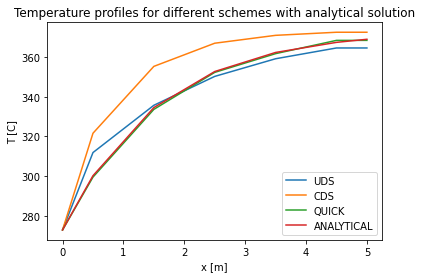

In [539]:
%matplotlib inline
import matplotlib.pyplot as plt

fig5, ax = plt.subplots()


ax.plot(x_an, T_UDS1, label="UDS")
ax.plot(x_an, T_CDS1, label="CDS")
ax.plot(x_an, T_QUICK1, label="QUICK")
ax.plot(x_an, T_an1, label="ANALYTICAL")


ax.set_title("Temperature profiles for different schemes with analytical solution")
ax.set_xlabel("x [m]")
ax.set_ylabel("T [C]")
ax.legend()
plt.show()

### 2. Class definition for positive flow direction for UDS, CDS and QUICK schemes with alphae on the right boundary positive.

In [547]:
import numpy as np

class UpwindAdvectionModel2:
    """Class defining an upwind advection model"""

    def __init__(self, grid, phi, Uhe, rho, cp, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._cp = cp
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)

    def add(self, coeffs):
        """Function to add advention terms to coefficient arrays"""

        # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
            else:
                self._alphae[i] = -1
        
        #To modify the value of alphae on the domains boundaries
        self._alphae [0] = 1 #Left boundary
        self._alphae [-1] = 1 #Right boundary
        
        # Calculate the east integration point values (including both boundaries)
        self._phie = (1 + self._alphae)/2*self._phi[0:-1] + (1 - self._alphae)/2*self._phi[1:]
        
        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = self._cp*mdote[:-1]*self._phie[:-1]
        flux_e = self._cp*mdote[1:]*self._phie[1:]
        
        # Calculate mass imbalance term
        imbalance = - self._cp*mdote[1:]*self._phi[1:-1] + self._cp*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._cp*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._cp*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs

In [548]:
class CenteredAdvectionModel2:
    """Class defining an upwind advection model with a central difference scheme"""

    def __init__(self, grid, phi, Uhe, rho, cp, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._cp = cp
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)

    def add(self, coeffs):
        """Function to add advention terms to coefficient arrays"""

        # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
            else:
                self._alphae[i] = -1
        
        #To modify the value of alphae on the domains boundaries
        self._alphae [0] = 1 #Left boundary
        self._alphae [-1] = 1 #Right boundary
        
       # Calculate the east integration point values (including both boundaries)
        self._phie[1:-1] = (self._phi[1:-2] + self._phi[2:-1])/2
        self._phie [0] = (1 + self._alphae[0])/2*self._phi[0] + (1 - self._alphae[0])/2*self._phi[1]
        self._phie[-1] = (1 + self._alphae[-1])/2*self._phi[-2] + (1 - self._alphae[-1])/2*self._phi[-1]
         

        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = (self._cp*mdote[:-1]/2)*self._phie[:-1]
        flux_e = (self._cp*mdote[1:]/2)*self._phie[1:]
        
        #flux_w = self._cp*mdote[:-1]*self._phie[:-1]
        #flux_e = self._cp*mdote[1:]*self._phie[1:]
        
        # Calculate mass imbalance term
        imbalance = - self._cp*mdote[1:]*self._phi[1:-1] + self._cp*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._cp*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._cp*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs

In [549]:
import numpy as np

class QUICKAdvectionModel2:
    """Class defining an upwind advection model with the QUICK scheme"""

    def __init__(self, grid, phi, Uhe, rho, cp, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._cp = cp
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)

    def add(self, coeffs):
        """Function to add advention terms to coefficient arrays"""

        # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
            else:
                self._alphae[i] = -1
        
        #To modify the value of alphae on the domains boundaries
        self._alphae [0] = 1 #Left boundary definition
        self._alphae [-1] = 1 #Right boundary definition        
        
        #To calculate the east integration point values of the interior control volume
        for i in range(self._grid.ncv):
            if self._Uhe[i] >= 0:
                TW = (((self._grid.xf[i] - self._grid.xP[i])*(self._grid.xf[i] - self._grid.xP[i+1]))/((self._grid.xP[i-1] - self._grid.xP[i])*(self._grid.xP[i-1] - self._grid.xP[i+1])))*self._phi[i-1]
                TP = ((self._grid.xf[i]-self._grid.xP[i-1])*(self._grid.xf[i]-self._grid.xP[i+1]))/((self._grid.xP[i]-self._grid.xP[i-1])*(self._grid.xP[i]-self._grid.xP[i+1]))*self._phi[i]
                TE = ((self._grid.xf[i]-self._grid.xP[i-1])*(self._grid.xf[i]-self._grid.xP[i]))/((self._grid.xP[i+1]-self._grid.xP[i-1])*(self._grid.xP[i+1]-self._grid.xP[i]))*self._phi[i+1] 
                self._phie[i] = TW + TP + TE
            else:
                for i in range(self._grid.ncv-1):
                    T_EE = (((self._grid.xf[i] - self._grid.xP[i+1])*(self._grid.xf[i] - self._grid.xP[i]))/((self._grid.xP[i+2] - self._grid.xP[i+1])*(self._grid.xP[i+2] - self._grid.xP[i])))*self._phi[i+2]
                    T_E = ((self._grid.xf[i] - self._grid.xP[i+2])*(self._grid.xf[i] - self._grid.xP[i]))/((self._grid.xP[i+1] - self._grid.xP[i+2])*(self._grid.xP[i+1] - self._grid.xP[i]))*self._phi[i+1]
                    T_P = ((self._grid.xf[i] - self._grid.xP[i+2])*(self._grid.xf[i] - self._grid.xP[i+1]))/((self._grid.xP[i+1] - self._grid.xP[i+2])*(self._grid.xP[i] - self._grid.xP[i+1]))*self._phi[i] 
                    self._phie[i] = T_EE + T_E + T_P

        # Calculate the east integration point values for the boundaries
        self._phie [0] = (1 + self._alphae[0])/2*self._phi[0] + (1 - self._alphae[0])/2*self._phi[1]
        self._phie[-1] = (1 + self._alphae[-1])/2*self._phi[-2] + (1 - self._alphae[-1])/2*self._phi[-1]

        
        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = self._cp*mdote[:-1]*self._phie[:-1]
        flux_e = self._cp*mdote[1:]*self._phie[1:]
        
        # Calculate mass imbalance term
        imbalance = - self._cp*mdote[1:]*self._phi[1:-1] + self._cp*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._cp*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._cp*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs

In [550]:
def UDS2 (ncv1,Uo):

    # Define the grid
    lx = 5.0
    ly = 0.01
    lz = 0.01
    ncv = ncv1
    grid = Grid(lx, ly, lz, ncv)

    # Set the timestep information
    nTime = 1
    dt = 10e10
    time = 0

    # Set the maximum number of iterations and convergence criterion
    maxIter = 100
    converged = 1e-6

    # Define thermophysical properties
    rho = 1000
    cp = 4189
    k = 0.590

    # Define the surface convection parameters
    ho = 10000
    To = 373

    # Define the coefficients
    coeffs = ScalarCoeffs(grid.ncv)

    # Initial conditions
    T0 = 273
    U0 = Uo #m/s

    # Initialize field variable arrays
    T = T0*np.ones(grid.ncv+2)
    Uhe = U0*np.ones(grid.ncv+1)

    # Define boundary conditions
    west_bc = DirichletBc(T, grid, 273, BoundaryLocation.WEST)
    east_bc = NeumannBc(T, grid, 0, BoundaryLocation.EAST)

    # Apply boundary conditions
    west_bc.apply()
    east_bc.apply()

    # Define the transient model
    Told = np.copy(T)
    transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

    # Define the diffusion model
    diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

    # Define the surface convection model
    surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

    # Define the advection model
    advection = UpwindAdvectionModel2(grid, T, Uhe, rho, cp, west_bc, east_bc)

    # Loop through all timesteps
    for tStep in range(nTime):
        # Update the time information
        time += dt

        # Print the timestep information
        print("Timestep = {}; Time = {}".format(tStep, time))

        # Store the "old" temperature field
        Told[:] = T[:]

        # Iterate until the solution is converged
        for i in range(maxIter):
            # Zero the coefficients and add each influence
            coeffs.zero()
            coeffs = diffusion.add(coeffs)
            coeffs = surfaceConvection.add(coeffs)
            coeffs = advection.add(coeffs)
            coeffs = transient.add(coeffs)

            # Compute residual and check for convergence 
            maxResid = norm(coeffs.rP, np.inf)
            avgResid = np.mean(np.absolute(coeffs.rP))
            print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
            if maxResid < converged:
                break

            # Solve the sparse matrix system
            dT = solve(coeffs)

            # Update the solution and boundary conditions
            T[1:-1] += dT
            west_bc.apply()
            east_bc.apply()
           
    return (T,grid.xP)


In [551]:
Uo = 1.5 #Define the velocity
T_UDS3, grid2 = UDS2(5,Uo)
print(T_UDS3)

Timestep = 0; Time = 100000000000.0
Iteration = 0; Max. Resid. = 40000.0; Avg. Resid. = 40000.0
Iteration = 1; Max. Resid. = 5.07429181982157e-11; Avg. Resid. = 3.5917825204870286e-11
[273.         311.89725951 335.6645524  350.18701918 359.06064404
 364.48267162 364.48267162]


In [552]:
def CDS3(ncv1,Uo):
    # Define the grid
    lx = 5.0
    ly = 0.01
    lz = 0.01
    ncv = ncv1
    grid = Grid(lx, ly, lz, ncv)

    # Set the timestep information
    nTime = 1
    dt = 10e10
    time = 0

    # Set the maximum number of iterations and convergence criterion
    maxIter = 100
    converged = 1e-6

    # Define thermophysical properties
    rho = 1000
    cp = 4189
    k = 0.590

    # Define the surface convection parameters
    ho = 10000
    To = 373

    # Define the coefficients
    coeffs = ScalarCoeffs(grid.ncv)

    # Initial conditions
    T0 = 273
    U0 = Uo #m/s

    # Initialize field variable arrays
    T = T0*np.ones(grid.ncv+2)
    Uhe = U0*np.ones(grid.ncv+1)

    # Define boundary conditions
    west_bc = DirichletBc(T, grid, 273, BoundaryLocation.WEST)
    east_bc = NeumannBc(T, grid, 0, BoundaryLocation.EAST)

    # Apply boundary conditions
    west_bc.apply()
    east_bc.apply()

    # Define the transient model
    Told = np.copy(T)
    transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

    # Define the diffusion model
    diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

    # Define the surface convection model
    surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

    # Define the advection model
    advection = CenteredAdvectionModel2(grid, T, Uhe, rho, cp, west_bc, east_bc)

    # Loop through all timesteps
    for tStep in range(nTime):
        # Update the time information
        time += dt

        # Print the timestep information
        print("Timestep = {}; Time = {}".format(tStep, time))

        # Store the "old" temperature field
        Told[:] = T[:]

        # Iterate until the solution is converged
        for i in range(maxIter):
            # Zero the coefficients and add each influence
            coeffs.zero()
            coeffs = diffusion.add(coeffs)
            coeffs = surfaceConvection.add(coeffs)
            coeffs = advection.add(coeffs)
            coeffs = transient.add(coeffs)

            # Compute residual and check for convergence 
            maxResid = norm(coeffs.rP, np.inf)
            avgResid = np.mean(np.absolute(coeffs.rP))
            print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
            if maxResid < converged:
                break

            # Solve the sparse matrix system
            dT = solve(coeffs)

            # Update the solution and boundary conditions
            T[1:-1] += dT
            west_bc.apply()
            east_bc.apply()


        return(T,grid.xP)

In [553]:
Uo = 1.5 #Definition of the velocity
T_CDS3, grid2 = CDS3(5,Uo)
print(T_CDS3)

Timestep = 0; Time = 100000000000.0
Iteration = 0; Max. Resid. = 40000.0; Avg. Resid. = 40000.0
Iteration = 1; Max. Resid. = 8919.335870556235; Avg. Resid. = 5748.313671223381
Iteration = 2; Max. Resid. = 2580.2040189169156; Avg. Resid. = 1248.746824819783
Iteration = 3; Max. Resid. = 1042.0768420056622; Avg. Resid. = 537.684652311211
Iteration = 4; Max. Resid. = 544.4577986777159; Avg. Resid. = 264.22444971821614
Iteration = 5; Max. Resid. = 324.97274688707574; Avg. Resid. = 151.53909616651734
Iteration = 6; Max. Resid. = 205.4787755466247; Avg. Resid. = 90.16252771625769
Iteration = 7; Max. Resid. = 133.23172905212823; Avg. Resid. = 57.58767849243645
Iteration = 8; Max. Resid. = 87.4467423631742; Avg. Resid. = 38.4703439022519
Iteration = 9; Max. Resid. = 57.788018943068145; Avg. Resid. = 25.644296793561455
Iteration = 10; Max. Resid. = 38.35610603960103; Avg. Resid. = 17.08836437074401
Iteration = 11; Max. Resid. = 25.539509345779372; Avg. Resid. = 11.392123077494386
Iteration = 12;

In [554]:
def QUICK3(ncv1,Uo):
    # Define the grid
    lx = 5.0
    ly = 0.01
    lz = 0.01
    ncv = ncv1
    grid = Grid(lx, ly, lz, ncv)

    # Set the timestep information
    nTime = 1
    dt = 10e10
    time = 0

    # Set the maximum number of iterations and convergence criterion
    maxIter = 100
    converged = 1e-6

    # Define thermophysical properties
    rho = 1000
    cp = 4189
    k = 0.590

    # Define the surface convection parameters
    ho = 10000
    To = 373

    # Define the coefficients
    coeffs = ScalarCoeffs(grid.ncv)

    # Initial conditions
    T0 = 273
    U0 = Uo #m/s

    # Initialize field variable arrays
    T = T0*np.ones(grid.ncv+2)
    Uhe = U0*np.ones(grid.ncv+1)

    # Define boundary conditions
    west_bc = DirichletBc(T, grid, 273, BoundaryLocation.WEST)
    east_bc = NeumannBc(T, grid, 0, BoundaryLocation.EAST)

    # Apply boundary conditions
    west_bc.apply()
    east_bc.apply()

    # Define the transient model
    Told = np.copy(T)
    transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

    # Define the diffusion model
    diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

    # Define the surface convection model
    surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

    # Define the advection model
    advection = QUICKAdvectionModel2(grid, T, Uhe, rho, cp, west_bc, east_bc)

    # Loop through all timesteps
    for tStep in range(nTime):
        # Update the time information
        time += dt

        # Print the timestep information
        print("Timestep = {}; Time = {}".format(tStep, time))

        # Store the "old" temperature field
        Told[:] = T[:]

        # Iterate until the solution is converged
        for i in range(maxIter):
            # Zero the coefficients and add each influence
            coeffs.zero()
            coeffs = diffusion.add(coeffs)
            coeffs = surfaceConvection.add(coeffs)
            coeffs = advection.add(coeffs)
            coeffs = transient.add(coeffs)

            # Compute residual and check for convergence 
            maxResid = norm(coeffs.rP, np.inf)
            avgResid = np.mean(np.absolute(coeffs.rP))
            print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
            if maxResid < converged:
                break

            # Solve the sparse matrix system
            dT = solve(coeffs)

            # Update the solution and boundary conditions
            T[1:-1] += dT
            west_bc.apply()
            east_bc.apply()


        return(T,grid.xP)

In [555]:
Uo = 1.5 #Definition of the velocity
T_QUICK3, grid3 = QUICK3(5,Uo)
print(T_QUICK3)

Timestep = 0; Time = 100000000000.0
Iteration = 0; Max. Resid. = 40000.0; Avg. Resid. = 40000.0
Iteration = 1; Max. Resid. = 13125.09050097039; Avg. Resid. = 5250.036200388156
Iteration = 2; Max. Resid. = 1513.5391189714521; Avg. Resid. = 605.4156475885886
Iteration = 3; Max. Resid. = 594.495479234694; Avg. Resid. = 237.79819169387278
Iteration = 4; Max. Resid. = 106.48614838869055; Avg. Resid. = 52.8668514065624
Iteration = 5; Max. Resid. = 24.59579347576484; Avg. Resid. = 9.838317390298545
Iteration = 6; Max. Resid. = 8.044481678515876; Avg. Resid. = 4.579300213774121
Iteration = 7; Max. Resid. = 3.162845283656812; Avg. Resid. = 1.6959148576865573
Iteration = 8; Max. Resid. = 0.8861230451901726; Avg. Resid. = 0.5395651734386586
Iteration = 9; Max. Resid. = 0.40393433846062055; Avg. Resid. = 0.16157373538115147
Iteration = 10; Max. Resid. = 0.14249184281658864; Avg. Resid. = 0.06949494611732852
Iteration = 11; Max. Resid. = 0.05416584742027809; Avg. Resid. = 0.02631239824187696
Iterat

## Discussion of the change of sign for the right boundary alphae.

The changes on alphae will define if the temperature to be used on the scheme at the right boundary will be Tp or Teast. Is possible to notice that for this case, the temperatures obtained in QUICK are the same for both cases where the right boundary alphae is1 and -1. For the case of the CDS, the temperatures profiles as well are similar between both cases. For the UDS scheme, the tempertures obtained have a slight difference between the two cases, despite the changes, this difference can be neglectable. This results obtained are realistic considering that the set up of this values of alphae guarantee that the correct value of T in the domain is carried out. 

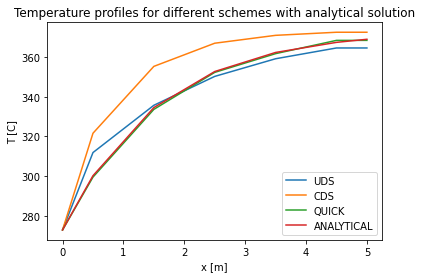

In [558]:
%matplotlib inline
import matplotlib.pyplot as plt

fig6, ax = plt.subplots()


ax.plot(x_an, T_UDS3, label="UDS")
ax.plot(x_an, T_CDS3, label="CDS")
ax.plot(x_an, T_QUICK3, label="QUICK")
ax.plot(x_an, T_an1, label="ANALYTICAL")


ax.set_title("Temperature profiles for different schemes with analytical solution")
ax.set_xlabel("x [m]")
ax.set_ylabel("T [C]")
ax.legend()
plt.show()

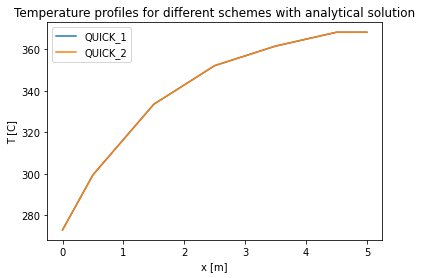

In [559]:
%matplotlib inline
import matplotlib.pyplot as plt

fig7, ax = plt.subplots()


ax.plot(x_an, T_QUICK1, label="QUICK_1")
ax.plot(x_an, T_QUICK3, label="QUICK_2")

ax.set_title("Temperature profiles for QUICK scheme for different set of right boundary of alphae")
ax.set_xlabel("x [m]")
ax.set_ylabel("T [C]")
ax.legend()
plt.show()

## Reverse flow direction

Since the change on the flow has to be applied with changes on the set up of a $\alpha_e$, the classes are going to be re defining using the new set up. This means that for this case the right boundary condition for $\alpha_e$ is going to remain in -1 and the left boundary condition will be analyzed for 1 and -1.

### Class definition for $\alpha_e$ = 1.0 at the left boundary condition

In [560]:
import numpy as np

class UpwindAdvectionModel3:
    """Class defining an upwind advection model"""

    def __init__(self, grid, phi, Uhe, rho, cp, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._cp = cp
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)

    def add(self, coeffs):
        """Function to add advention terms to coefficient arrays"""

        # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
            else:
                self._alphae[i] = -1
        
        #To modify the value of alphae on the domains boundaries
        self._alphae[0] = 1
        self._alphae [-1] = -1 #Right boundary
        
        # Calculate the east integration point values (including both boundaries)
        self._phie = (1 + self._alphae)/2*self._phi[0:-1] + (1 - self._alphae)/2*self._phi[1:]
        
        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = self._cp*mdote[:-1]*self._phie[:-1]
        flux_e = self._cp*mdote[1:]*self._phie[1:]
        
        # Calculate mass imbalance term
        imbalance = - self._cp*mdote[1:]*self._phi[1:-1] + self._cp*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._cp*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._cp*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs

In [561]:
class CenteredAdvectionModel3:
    """Class defining an upwind advection model with a central difference scheme"""

    def __init__(self, grid, phi, Uhe, rho, cp, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._cp = cp
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)

    def add(self, coeffs):
        """Function to add advention terms to coefficient arrays"""

        # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
            else:
                self._alphae[i] = -1
        
        #To modify the value of alphae on the domains boundaries
        self._alphae [0] = 1
        self._alphae [-1] = -1 #Right boundary
        
       # Calculate the east integration point values (including both boundaries)
        self._phie[1:-1] = (self._phi[1:-2] + self._phi[2:-1])/2
        self._phie [0] = (1 + self._alphae[0])/2*self._phi[0] + (1 - self._alphae[0])/2*self._phi[1]
        self._phie[-1] = (1 + self._alphae[-1])/2*self._phi[-2] + (1 - self._alphae[-1])/2*self._phi[-1]
         

        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = (self._cp*mdote[:-1]/2)*self._phie[:-1]
        flux_e = (self._cp*mdote[1:]/2)*self._phie[1:]
        
        #flux_w = self._cp*mdote[:-1]*self._phie[:-1]
        #flux_e = self._cp*mdote[1:]*self._phie[1:]
        
        # Calculate mass imbalance term
        imbalance = - self._cp*mdote[1:]*self._phi[1:-1] + self._cp*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._cp*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._cp*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs

In [562]:
import numpy as np

class QUICKAdvectionModel3:
    """Class defining an upwind advection model with the QUICK scheme"""

    def __init__(self, grid, phi, Uhe, rho, cp, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._cp = cp
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)

    def add(self, coeffs):
        """Function to add advention terms to coefficient arrays"""

        # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
            else:
                self._alphae[i] = -1
        
        #To modify the value of alphae on the domains boundaries
        self._alphae [0] = 1 #Left boundary definition
        self._alphae [-1] = -1 #Right boundary definition        
        
        #To calculate the east integration point values of the interior control volume
        for i in range(self._grid.ncv):
            if self._Uhe[i] >= 0:
                TW = (((self._grid.xf[i] - self._grid.xP[i])*(self._grid.xf[i] - self._grid.xP[i+1]))/((self._grid.xP[i-1] - self._grid.xP[i])*(self._grid.xP[i-1] - self._grid.xP[i+1])))*self._phi[i-1]
                TP = ((self._grid.xf[i]-self._grid.xP[i-1])*(self._grid.xf[i]-self._grid.xP[i+1]))/((self._grid.xP[i]-self._grid.xP[i-1])*(self._grid.xP[i]-self._grid.xP[i+1]))*self._phi[i]
                TE = ((self._grid.xf[i]-self._grid.xP[i-1])*(self._grid.xf[i]-self._grid.xP[i]))/((self._grid.xP[i+1]-self._grid.xP[i-1])*(self._grid.xP[i+1]-self._grid.xP[i]))*self._phi[i+1] 
                self._phie[i] = TW + TP + TE
            else:
                for i in range (self._grid.ncv-1):
                    TEE = ((self._grid.xf[i] - self._grid.xP[i+1])*(self._grid.xf[i] - self._grid.xP[i]))/((self._grid.xP[i+2] - self._grid.xP[i+1])*(self._grid.xP[i+2] - self._grid.xP[i]))*self._phi[i+2]
                    TE = ((self._grid.xf[i] - self._grid.xP[i+2])*(self._grid.xf[i] - self._grid.xP[i]))/((self._grid.xP[i+1] - self._grid.xP[i+2])*(self._grid.xP[i+1] - self._grid.xP[i]))*self._phi[i+1]
                    TP = ((self._grid.xf[i] - self._grid.xP[i+2])*(self._grid.xf[i] - self._grid.xP[i+1]))/((self._grid.xP[i+1] - self._grid.xP[i+2])*(self._grid.xP[i] - self._grid.xP[i+1]))*self._phi[i]
                    self._phie[i] = TEE + TE + TP

        # Calculate the east integration point values for the boundaries
        self._phie [0] = (1 + self._alphae[0])/2*self._phi[0] + (1 - self._alphae[0])/2*self._phi[1]
        self._phie[-1] = (1 + self._alphae[-1])/2*self._phi[-2] + (1 - self._alphae[-1])/2*self._phi[-1]

        
        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = self._cp*mdote[:-1]*self._phie[:-1]
        flux_e = self._cp*mdote[1:]*self._phie[1:]
        
        # Calculate mass imbalance term
        imbalance = - self._cp*mdote[1:]*self._phi[1:-1] + self._cp*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._cp*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._cp*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs

## Main codes

## UDS

In [563]:
# Define the grid
lx = 5.0
ly = 0.01
lz = 0.01
ncv = 5
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 1
dt = 10e10
time = 0

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
rho = 1000
cp = 4189
k = 0.590

# Define the surface convection parameters
ho = 10000
To = 373

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 273
U0 = -1.5 #m/s

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)
Uhe = U0*np.ones(grid.ncv+1)

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 273, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Define the advection model
advection = UpwindAdvectionModel3(grid, T, Uhe, rho, cp, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt

    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))

    # Store the "old" temperature field
    Told[:] = T[:]

    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = surfaceConvection.add(coeffs)
        coeffs = advection.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break

        # Solve the sparse matrix system
        dT = solve(coeffs)

        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()

T_UDS4 = T
print(T_UDS4)

Timestep = 0; Time = 100000000000.0
Iteration = 0; Max. Resid. = 40000.0; Avg. Resid. = 40000.0
Iteration = 1; Max. Resid. = 5.07429181982157e-11; Avg. Resid. = 3.5917825204870286e-11
[364.48267162 364.48267162 359.06064404 350.18701918 335.6645524
 311.89725951 273.        ]


## CDS

In [564]:
def CDS5(ncv1,Uo):
    # Define the grid
    lx = 5.0
    ly = 0.01
    lz = 0.01
    ncv = ncv1
    grid = Grid(lx, ly, lz, ncv)

    # Set the timestep information
    nTime = 1
    dt = 10e10
    time = 0

    # Set the maximum number of iterations and convergence criterion
    maxIter = 100
    converged = 1e-6

    # Define thermophysical properties
    rho = 1000
    cp = 4189
    k = 0.590

    # Define the surface convection parameters
    ho = 10000
    To = 373

    # Define the coefficients
    coeffs = ScalarCoeffs(grid.ncv)

    # Initial conditions
    T0 = 273
    U0 = Uo #m/s

    # Initialize field variable arrays
    T = T0*np.ones(grid.ncv+2)
    Uhe = U0*np.ones(grid.ncv+1)

    # Define boundary conditions
    west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
    east_bc = DirichletBc(T, grid, 273, BoundaryLocation.EAST)

    # Apply boundary conditions
    west_bc.apply()
    east_bc.apply()

    # Define the transient model
    Told = np.copy(T)
    transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

    # Define the diffusion model
    diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

    # Define the surface convection model
    surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

    # Define the advection model
    advection = CenteredAdvectionModel3(grid, T, Uhe, rho, cp, west_bc, east_bc)

    # Loop through all timesteps
    for tStep in range(nTime):
        # Update the time information
        time += dt

        # Print the timestep information
        print("Timestep = {}; Time = {}".format(tStep, time))

        # Store the "old" temperature field
        Told[:] = T[:]

        # Iterate until the solution is converged
        for i in range(maxIter):
            # Zero the coefficients and add each influence
            coeffs.zero()
            coeffs = diffusion.add(coeffs)
            coeffs = surfaceConvection.add(coeffs)
            coeffs = advection.add(coeffs)
            coeffs = transient.add(coeffs)

            # Compute residual and check for convergence 
            maxResid = norm(coeffs.rP, np.inf)
            avgResid = np.mean(np.absolute(coeffs.rP))
            print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
            if maxResid < converged:
                break

            # Solve the sparse matrix system
            dT = solve(coeffs)

            # Update the solution and boundary conditions
            T[1:-1] += dT
            west_bc.apply()
            east_bc.apply()


        return(T,grid.xP)

In [565]:
Uo = -1.5
T_CDS4, grid2 = CDS5(5,Uo)
print(T_CDS4)

Timestep = 0; Time = 100000000000.0
Iteration = 0; Max. Resid. = 40000.0; Avg. Resid. = 40000.0
Iteration = 1; Max. Resid. = 8919.335870556235; Avg. Resid. = 5748.31367122338
Iteration = 2; Max. Resid. = 2580.2040189169156; Avg. Resid. = 1248.746824819783
Iteration = 3; Max. Resid. = 1042.0768420056622; Avg. Resid. = 537.684652311211
Iteration = 4; Max. Resid. = 544.4577986777159; Avg. Resid. = 264.2244497182161
Iteration = 5; Max. Resid. = 324.97274688707574; Avg. Resid. = 151.5390961665173
Iteration = 6; Max. Resid. = 205.4787755466247; Avg. Resid. = 90.16252771625769
Iteration = 7; Max. Resid. = 133.23172905212823; Avg. Resid. = 57.58767849243644
Iteration = 8; Max. Resid. = 87.4467423631742; Avg. Resid. = 38.4703439022519
Iteration = 9; Max. Resid. = 57.788018943068145; Avg. Resid. = 25.644296793561455
Iteration = 10; Max. Resid. = 38.35610603960103; Avg. Resid. = 17.08836437074401
Iteration = 11; Max. Resid. = 25.539509345779372; Avg. Resid. = 11.392123077494386
Iteration = 12; Ma

In [566]:
def QUICK4(ncv1,Uo):
    # Define the grid
    lx = 5.0
    ly = 0.01
    lz = 0.01
    ncv = ncv1
    grid = Grid(lx, ly, lz, ncv)

    # Set the timestep information
    nTime = 1
    dt = 10e10
    time = 0

    # Set the maximum number of iterations and convergence criterion
    maxIter = 100
    converged = 1e-6

    # Define thermophysical properties
    rho = 1000
    cp = 4189
    k = 0.590

    # Define the surface convection parameters
    ho = 10000
    To = 373

    # Define the coefficients
    coeffs = ScalarCoeffs(grid.ncv)

    # Initial conditions
    T0 = 273
    U0 = Uo #m/s

    # Initialize field variable arrays
    T = T0*np.ones(grid.ncv+2)
    Uhe = U0*np.ones(grid.ncv+1)

    # Define boundary conditions
    west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
    east_bc = DirichletBc(T, grid, 273, BoundaryLocation.EAST)

    # Apply boundary conditions
    west_bc.apply()
    east_bc.apply()

    # Define the transient model
    Told = np.copy(T)
    transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

    # Define the diffusion model
    diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

    # Define the surface convection model
    surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

    # Define the advection model
    advection = QUICKAdvectionModel3(grid, T, Uhe, rho, cp, west_bc, east_bc)

    # Loop through all timesteps
    for tStep in range(nTime):
        # Update the time information
        time += dt

        # Print the timestep information
        print("Timestep = {}; Time = {}".format(tStep, time))

        # Store the "old" temperature field
        Told[:] = T[:]

        # Iterate until the solution is converged
        for i in range(maxIter):
            # Zero the coefficients and add each influence
            coeffs.zero()
            coeffs = diffusion.add(coeffs)
            coeffs = surfaceConvection.add(coeffs)
            coeffs = advection.add(coeffs)
            coeffs = transient.add(coeffs)

            # Compute residual and check for convergence 
            maxResid = norm(coeffs.rP, np.inf)
            avgResid = np.mean(np.absolute(coeffs.rP))
            print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
            if maxResid < converged:
                break

            # Solve the sparse matrix system
            dT = solve(coeffs)

            # Update the solution and boundary conditions
            T[1:-1] += dT
            west_bc.apply()
            east_bc.apply()


    return(T,grid.xP)

In [567]:
Uo = -1.5
T_QUICK4, grid2 = QUICK4(5,Uo)
print(T_QUICK4)

Timestep = 0; Time = 100000000000.0
Iteration = 0; Max. Resid. = 211539.55000000002; Avg. Resid. = 118346.75250000002
Iteration = 1; Max. Resid. = 129256.43113942069; Avg. Resid. = 72862.38523393201
Iteration = 2; Max. Resid. = 78979.2025492371; Avg. Resid. = 39752.16888392358
Iteration = 3; Max. Resid. = 48258.44636511483; Avg. Resid. = 23997.195537561056
Iteration = 4; Max. Resid. = 29487.226426125497; Avg. Resid. = 15189.546586669143
Iteration = 5; Max. Resid. = 18359.662597282495; Avg. Resid. = 8547.108859503633
Iteration = 6; Max. Resid. = 11009.182989373767; Avg. Resid. = 4657.679558542085
Iteration = 7; Max. Resid. = 6726.910890539841; Avg. Resid. = 2911.70793878544
Iteration = 8; Max. Resid. = 4110.325950460022; Avg. Resid. = 1690.0634155190746
Iteration = 9; Max. Resid. = 2511.5212341528963; Avg. Resid. = 1004.6084936611609
Iteration = 10; Max. Resid. = 1534.607961396409; Avg. Resid. = 613.8431845585651
Iteration = 11; Max. Resid. = 937.6873110030624; Avg. Resid. = 375.0749244

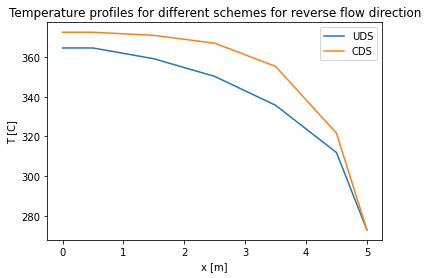

In [568]:
%matplotlib inline
import matplotlib.pyplot as plt

fig7, ax = plt.subplots()


ax.plot(x_an, T_UDS4, label="UDS")
ax.plot(x_an, T_CDS4, label="CDS")
#ax.plot(x_an, T_QUICK4, label="QUICK")



ax.set_title("Temperature profiles for different schemes for reverse flow direction")
ax.set_xlabel("x [m]")
ax.set_ylabel("T [C]")
ax.legend()
plt.show()

### For $\alpha_e$ = -1.0 at the left boundary condition

In [569]:
import numpy as np

class UpwindAdvectionModel4:
    """Class defining an upwind advection model"""

    def __init__(self, grid, phi, Uhe, rho, cp, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._cp = cp
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)

    def add(self, coeffs):
        """Function to add advention terms to coefficient arrays"""

        # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
            else:
                self._alphae[i] = -1
        
        #To modify the value of alphae on the domains boundaries
        self._alphae[0] = -1
        self._alphae [-1] = -1 #Right boundary
        
        # Calculate the east integration point values (including both boundaries)
        self._phie = (1 + self._alphae)/2*self._phi[0:-1] + (1 - self._alphae)/2*self._phi[1:]
        
        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = self._cp*mdote[:-1]*self._phie[:-1]
        flux_e = self._cp*mdote[1:]*self._phie[1:]
        
        # Calculate mass imbalance term
        imbalance = - self._cp*mdote[1:]*self._phi[1:-1] + self._cp*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._cp*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._cp*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs

In [570]:
class CenteredAdvectionModel4:
    """Class defining an upwind advection model with a central difference scheme"""

    def __init__(self, grid, phi, Uhe, rho, cp, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._cp = cp
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)

    def add(self, coeffs):
        """Function to add advention terms to coefficient arrays"""

        # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
            else:
                self._alphae[i] = -1
        
        #To modify the value of alphae on the domains boundaries
        self._alphae [0] = -1
        self._alphae [-1] = -1 #Right boundary
        
       # Calculate the east integration point values (including both boundaries)
        self._phie[1:-1] = (self._phi[1:-2] + self._phi[2:-1])/2
        self._phie [0] = (1 + self._alphae[0])/2*self._phi[0] + (1 - self._alphae[0])/2*self._phi[1]
        self._phie[-1] = (1 + self._alphae[-1])/2*self._phi[-2] + (1 - self._alphae[-1])/2*self._phi[-1]
         

        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = (self._cp*mdote[:-1]/2)*self._phie[:-1]
        flux_e = (self._cp*mdote[1:]/2)*self._phie[1:]
        
        #flux_w = self._cp*mdote[:-1]*self._phie[:-1]
        #flux_e = self._cp*mdote[1:]*self._phie[1:]
        
        # Calculate mass imbalance term
        imbalance = - self._cp*mdote[1:]*self._phi[1:-1] + self._cp*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._cp*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._cp*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs

## UDS

In [571]:
# Define the grid
lx = 5.0
ly = 0.01
lz = 0.01
ncv = 5
grid = Grid(lx, ly, lz, ncv)

# Set the timestep information
nTime = 1
dt = 10e10
time = 0

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
rho = 1000
cp = 4189
k = 0.590

# Define the surface convection parameters
ho = 10000
To = 373

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 273
U0 = -1.5 #m/s

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)
Uhe = U0*np.ones(grid.ncv+1)

# Define boundary conditions
west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 273, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Define the transient model
Told = np.copy(T)
transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Define the advection model
advection = UpwindAdvectionModel4(grid, T, Uhe, rho, cp, west_bc, east_bc)

# Loop through all timesteps
for tStep in range(nTime):
    # Update the time information
    time += dt

    # Print the timestep information
    print("Timestep = {}; Time = {}".format(tStep, time))

    # Store the "old" temperature field
    Told[:] = T[:]

    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = surfaceConvection.add(coeffs)
        coeffs = advection.add(coeffs)
        coeffs = transient.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break

        # Solve the sparse matrix system
        dT = solve(coeffs)

        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()

T_UDS5 = T
print(T_UDS5)

Timestep = 0; Time = 100000000000.0
Iteration = 0; Max. Resid. = 40000.0; Avg. Resid. = 40000.0
Iteration = 1; Max. Resid. = 5.07429181982157e-11; Avg. Resid. = 3.5917825204870286e-11
[364.48267162 364.48267162 359.06064404 350.18701918 335.6645524
 311.89725951 273.        ]


In [572]:
def CDS6(ncv1,Uo):
    # Define the grid
    lx = 5.0
    ly = 0.01
    lz = 0.01
    ncv = ncv1
    grid = Grid(lx, ly, lz, ncv)

    # Set the timestep information
    nTime = 1
    dt = 10e10
    time = 0

    # Set the maximum number of iterations and convergence criterion
    maxIter = 100
    converged = 1e-6

    # Define thermophysical properties
    rho = 1000
    cp = 4189
    k = 0.590

    # Define the surface convection parameters
    ho = 10000
    To = 373

    # Define the coefficients
    coeffs = ScalarCoeffs(grid.ncv)

    # Initial conditions
    T0 = 273
    U0 = Uo #m/s

    # Initialize field variable arrays
    T = T0*np.ones(grid.ncv+2)
    Uhe = U0*np.ones(grid.ncv+1)

    # Define boundary conditions
    west_bc = NeumannBc(T, grid, 0, BoundaryLocation.WEST)
    east_bc = DirichletBc(T, grid, 273, BoundaryLocation.EAST)

    # Apply boundary conditions
    west_bc.apply()
    east_bc.apply()

    # Define the transient model
    Told = np.copy(T)
    transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

    # Define the diffusion model
    diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

    # Define the surface convection model
    surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

    # Define the advection model
    advection = CenteredAdvectionModel4(grid, T, Uhe, rho, cp, west_bc, east_bc)

    # Loop through all timesteps
    for tStep in range(nTime):
        # Update the time information
        time += dt

        # Print the timestep information
        print("Timestep = {}; Time = {}".format(tStep, time))

        # Store the "old" temperature field
        Told[:] = T[:]

        # Iterate until the solution is converged
        for i in range(maxIter):
            # Zero the coefficients and add each influence
            coeffs.zero()
            coeffs = diffusion.add(coeffs)
            coeffs = surfaceConvection.add(coeffs)
            coeffs = advection.add(coeffs)
            coeffs = transient.add(coeffs)

            # Compute residual and check for convergence 
            maxResid = norm(coeffs.rP, np.inf)
            avgResid = np.mean(np.absolute(coeffs.rP))
            print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
            if maxResid < converged:
                break

            # Solve the sparse matrix system
            dT = solve(coeffs)

            # Update the solution and boundary conditions
            T[1:-1] += dT
            west_bc.apply()
            east_bc.apply()


        return(T,grid.xP)

In [577]:
Uo = -1.5
T_CDS5, grid2 = CDS6(5,Uo)
print(T_CDS5)

Timestep = 0; Time = 100000000000.0
Iteration = 0; Max. Resid. = 40000.0; Avg. Resid. = 40000.0
Iteration = 1; Max. Resid. = 8919.335870556235; Avg. Resid. = 5748.31367122338
Iteration = 2; Max. Resid. = 2580.2040189169156; Avg. Resid. = 1248.746824819783
Iteration = 3; Max. Resid. = 1042.0768420056622; Avg. Resid. = 537.684652311211
Iteration = 4; Max. Resid. = 544.4577986777159; Avg. Resid. = 264.2244497182161
Iteration = 5; Max. Resid. = 324.97274688707574; Avg. Resid. = 151.5390961665173
Iteration = 6; Max. Resid. = 205.4787755466247; Avg. Resid. = 90.16252771625769
Iteration = 7; Max. Resid. = 133.23172905212823; Avg. Resid. = 57.58767849243644
Iteration = 8; Max. Resid. = 87.4467423631742; Avg. Resid. = 38.4703439022519
Iteration = 9; Max. Resid. = 57.788018943068145; Avg. Resid. = 25.644296793561455
Iteration = 10; Max. Resid. = 38.35610603960103; Avg. Resid. = 17.08836437074401
Iteration = 11; Max. Resid. = 25.539509345779372; Avg. Resid. = 11.392123077494386
Iteration = 12; Ma

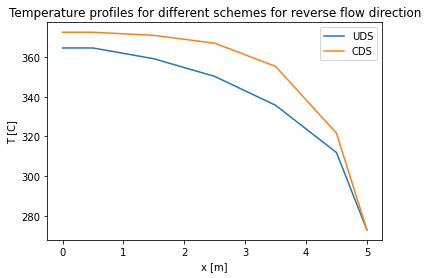

In [578]:
%matplotlib inline
import matplotlib.pyplot as plt

fig8, ax = plt.subplots()


ax.plot(grid2, T_UDS5, label="UDS")
ax.plot(grid2, T_CDS5, label="CDS")
#ax.plot(x_an, T_QUICK4, label="QUICK")



ax.set_title("Temperature profiles for different schemes for reverse flow direction")
ax.set_xlabel("x [m]")
ax.set_ylabel("T [C]")
ax.legend()
plt.show()